Link: https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

['calories.csv', 'exercise.csv']


In [2]:
import arviz as az

In [3]:
import pandas as pd
import numpy as np

# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

# Linear Regression to verify implementation
from sklearn.linear_model import LinearRegression

# Scipy for statistics
import scipy

# PyMC3 for Bayesian Inference
import pymc3 as pm

In [37]:
import random

In [4]:
data = './input/'
exercise = pd.read_csv(data + 'exercise.csv')
calories = pd.read_csv(data + 'calories.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df = df[df['Calories'] < 300]
df = df.reset_index()
df['Intercept'] = 1
df.head()

,index,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Intercept
0,0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,1
1,1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,1
2,2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,1
3,3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,1
4,4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,1


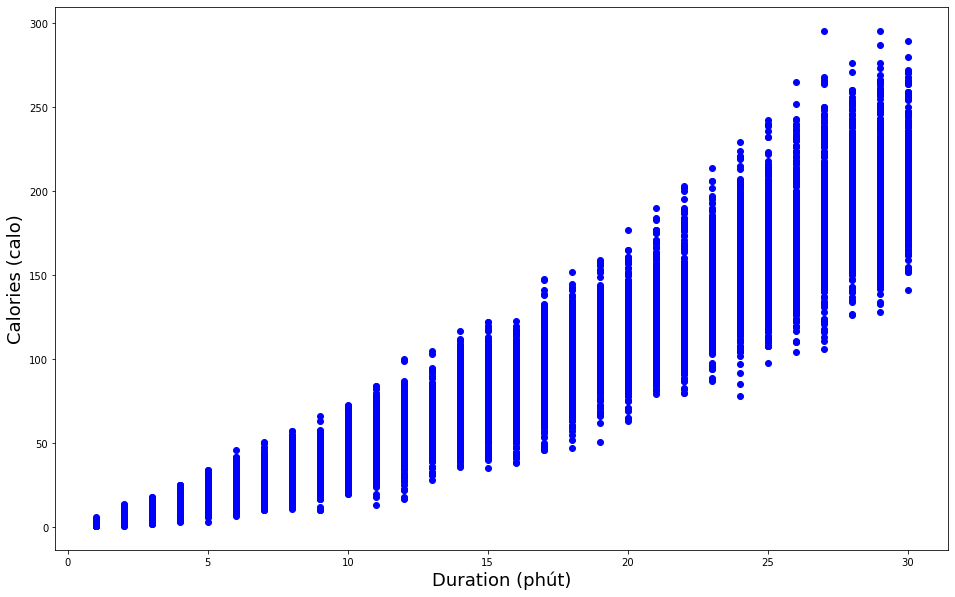

In [5]:
plt.figure(figsize=(16, 10))
# plt.grid()

plt.plot(df['Duration'], df['Calories'], 'bo')
plt.xlabel('Duration (phút)', size = 18)
plt.ylabel('Calories (calo)', size = 18); 
# plt.title('Lượng calo được đốt cháy', size = 20, y= -0.2);

In [6]:
# Create the features and response
X = df.loc[:, ['Intercept', 'Duration']]
y = df.loc[:, 'Calories']

In [7]:
print(X.shape)
print(y.shape)

(14998, 2)
(14998,)


# Ordinary Least squares linear regression by hand

In [8]:
linear_regression = LinearRegression()
linear_regression.fit(np.array(X.Duration).reshape(-1,1),y)
print('Intercept from library:', linear_regression.intercept_)
print('Slope from library:', linear_regression.coef_[0])

Intercept from library: -21.828102526050614
Slope from library: 7.16978334958784


$ y = \beta_0 + \beta_1 X$ <br>
$\beta_0 = -21.828102526050614$ <br>
$\beta_1 = 7.16978334958784$

In [9]:
by_hand_coefs = [linear_regression.intercept_, linear_regression.coef_[0]]

In [10]:
by_hand_coefs

[-21.828102526050614, 7.16978334958784]

# Bayesian Linear Regression

### Model with 500 Observations

In [11]:
y_pred_500 = np.array(linear_regression.intercept_ + linear_regression.coef_[0]*X["Duration"][:500])

In [12]:
y_true_500 = np.array(y[:500])

In [14]:
print(len(y_pred_500))
print(len(y_true_500))

500
500


In [15]:
def get_estimate_sigma(y_true, y_pred, num_data):
    sigma_square = np.sum((y_true - y_pred)**2)/(num_data-2)
    sigma = sigma_square**0.5
    return sigma

In [17]:
sigma_500 = get_estimate_sigma(y_true = y_true_500, y_pred = y_pred_500, num_data = len(y_true_500))
print(sigma_500)
print(sigma_500**2)

18.398792324888596
338.5155590143795


#### Chạy code để ra được phân phối hậu nghiệm của $\beta_0$ và $\beta_1$

In [19]:
X_train500 = np.array(X.loc[0:499, 'Duration'])

In [48]:
with pm.Model() as linear_model_500:
    # Intercept
    intercept = pm.Normal('beta_0', mu = 0, sd = 10) ## tiên nghiệm
    
    # Slope 
    slope = pm.Normal('beta_1', mu = 0, sd = 10)
    
#     # Standard deviation
#     sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X_train500
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma_500, observed = y_true_500) ## likelihood
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace_500 = pm.sample(1000, step, random_seed = 0)

C:\Users\Lennovo\AppData\Roaming\Python\Python38\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_1, beta_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8818922848636641, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Lennovo\AppData\Roaming\Python\Python38\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


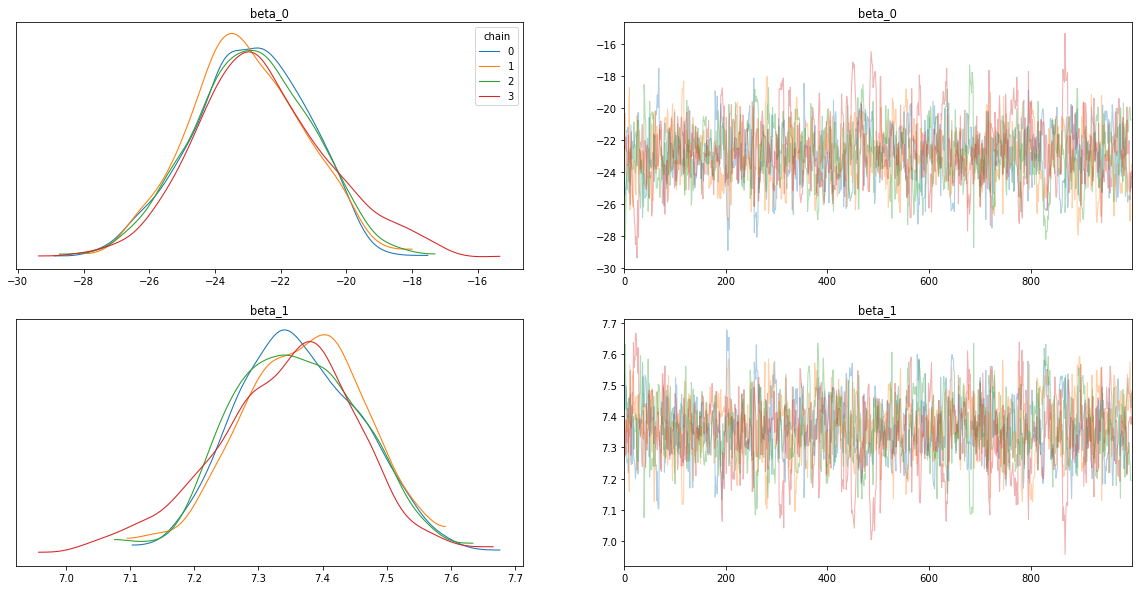

In [49]:
## vẽ phân phối hậu nghiệm của beta_0 và beta_1
az.plot_trace(linear_trace_500, figsize = (20, 10), compact = False, legend = True);

In [50]:
## hiển thị các thông tin phân phối hậu nghiệm của beta_0 và beta_1
with linear_model_500:
    trace500_az = az.from_pymc3(linear_trace_500)
az.summary(trace500_az)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-22.861,1.845,-26.318,-19.517,0.066,0.047,778.0,749.0,1.01
beta_1,7.358,0.102,7.171,7.549,0.004,0.003,807.0,785.0,1.01


In [57]:
print(linear_trace_500["beta_0"].mean())
print(linear_trace_500["beta_0"].std())

-22.860685679695308
1.8449382902863556


In [58]:
print(linear_trace_500["beta_1"].mean())
print(linear_trace_500["beta_1"].std())

7.35831295364101
0.10202828966490174


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Lennovo\AppData\Roaming\Python\Python38\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


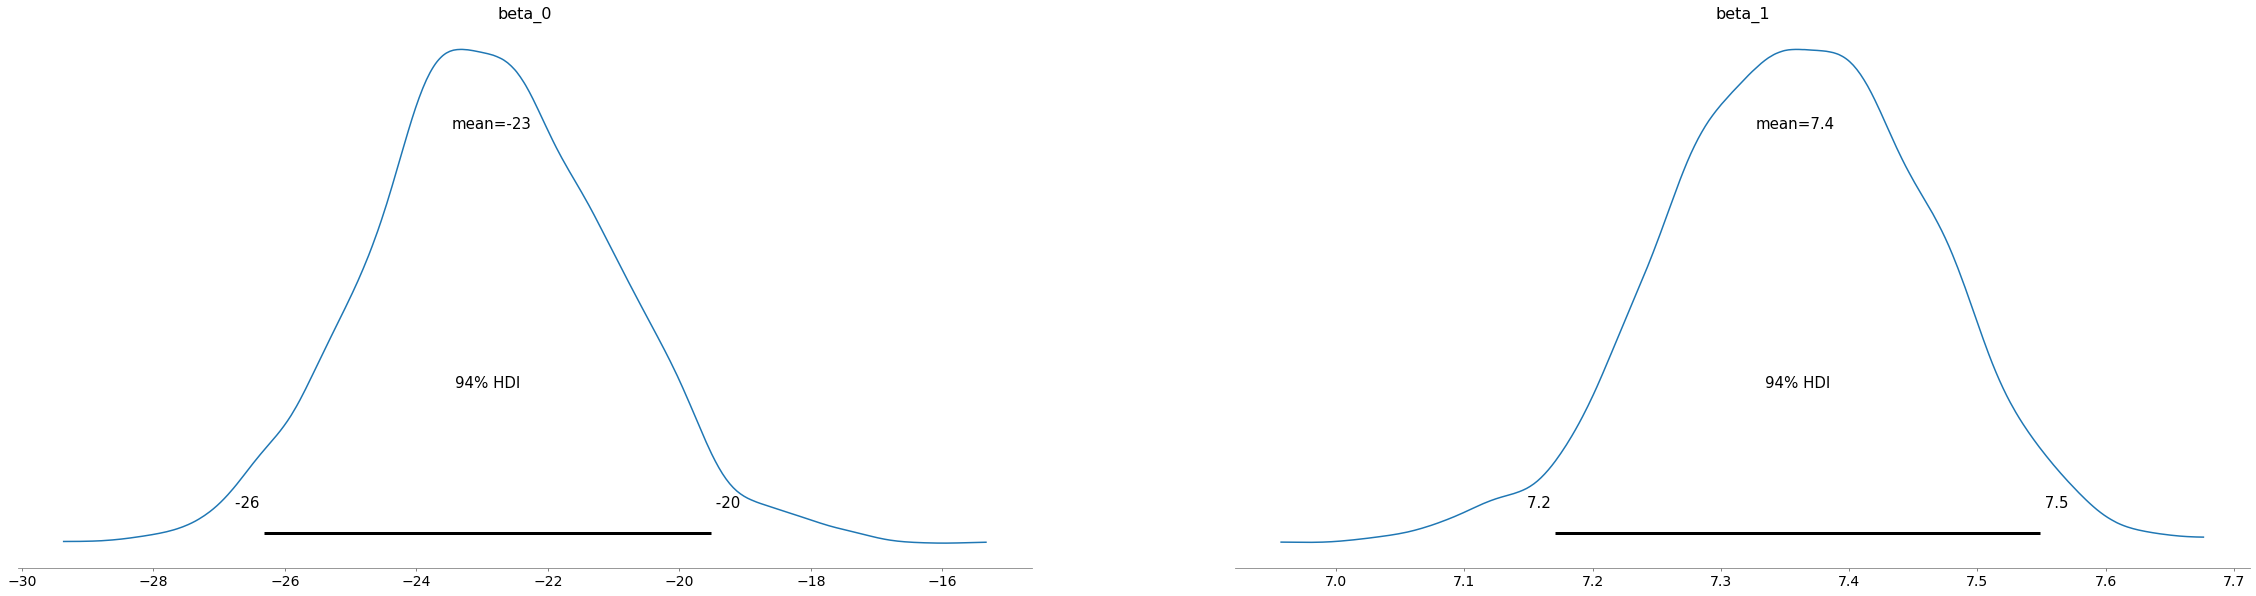

In [113]:
# vẽ phân phối hậu nghiệm của beta_0 và beta_1

pm.plot_posterior(linear_trace_500, figsize = (40,10));

In [63]:
## Dự đoán với điểm dữ liệu x = 15.5
bayes_prediction500 = linear_trace_500['beta_0'] + linear_trace_500['beta_1'] * 15.5

In [107]:
bayes_prediction500.mean()

91.19316510174036

In [114]:
bayes_prediction500.std()

0.8247309250488521

C:\Users\Lennovo\AppData\Roaming\Python\Python38\site-packages\pymc3\plots\posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


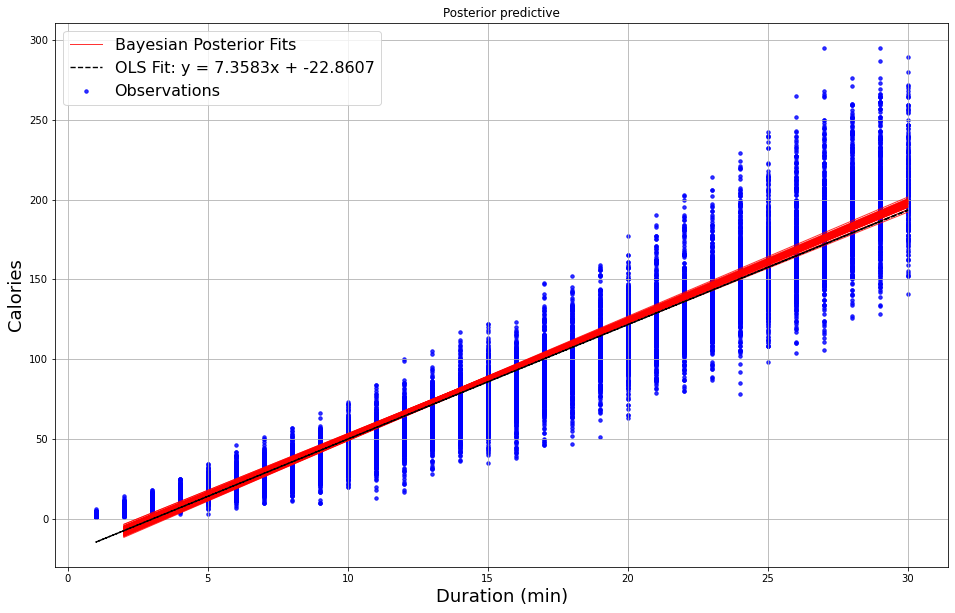

In [119]:
plt.figure(figsize = (16,10))
pm.plot_posterior_predictive_glm(linear_trace_500, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['beta_0'] + sample['beta_1'] * x);
plt.scatter(X['Duration'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X_train500, by_hand_coefs[0] + X_train500 * by_hand_coefs[1], 'k--', label = f'OLS Fit: y = {slope500_m:.4f}x + {Intercept500_m:.4f}', linewidth = 1.4)
# plt.title('Dự đoán ', size = 20);
plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.grid()
plt.legend(prop={'size': 16});

In [160]:
print(bayes_prediction500.std())

0.8247309250488521


In [161]:
# tính khoảng tin cậy 95% cho dự báo điểm dữ liệu 15.5
low_500 = bayes_prediction500.mean() - 1.96*bayes_prediction500.std()
high_500 = bayes_prediction500.mean() + 1.96*bayes_prediction500.std()
# print((low_500, high_500))
print((round(low_500, 4), round(high_500, 4)))

(89.5767, 92.8096)


In [126]:
sns.kdeplot?

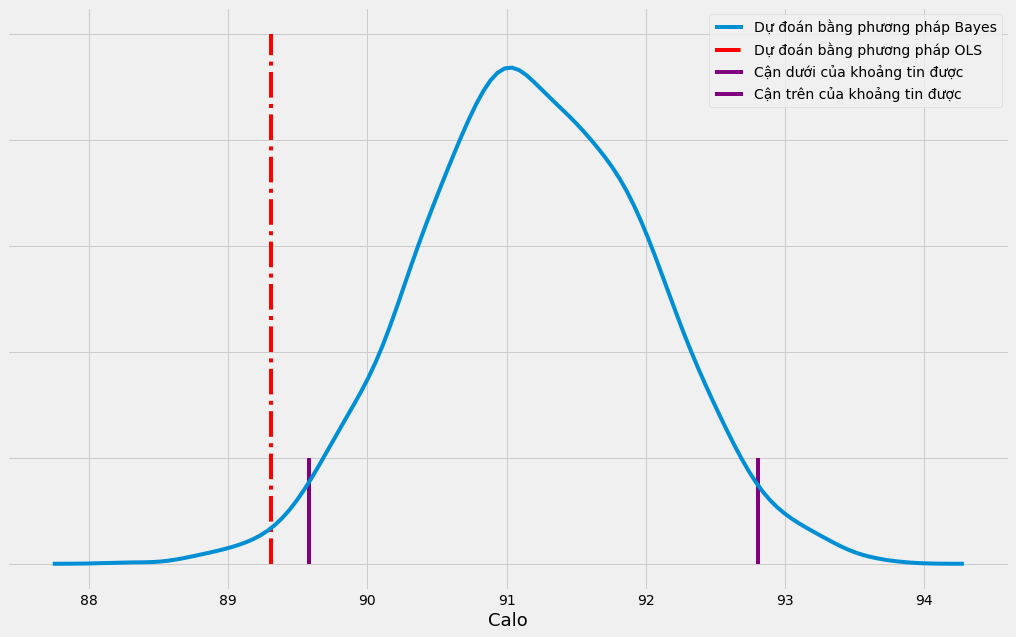

In [139]:
# vẽ phân phối predict cho 15.5
plt.figure(figsize = (16,10))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction500, label = 'Dự đoán bằng phương pháp Bayes')
plt.vlines(x = by_hand_coefs[0] + by_hand_coefs[1] * 15.5, 
           ymin = 0, ymax = 0.5, 
           label = 'Dự đoán bằng phương pháp OLS',
          colors = 'red', linestyles='-.')
plt.vlines(x = low_500, 
           ymin = 0, ymax = 0.1, 
           label = 'Cận dưới của khoảng tin được',
          colors = 'purple', linestyles='-')
plt.vlines(x = high_500, 
           ymin = 0, ymax = 0.1, 
           label = 'Cận trên của khoảng tin được',
          colors = 'purple', linestyles='-')
plt.legend();
plt.xlabel('Calo', size = 18)
# plt.fill_between(bayes_prediction500, bayes_prediction500, where=(low_500 < bayes_prediction500) & (bayes_prediction500 < high_500))
# plt.ylabel('Probability Density', size = 18);
# plt.title('Posterior Prediction for 15.5 Minutes', size = 20);
plt.tick_params(labelleft=False, left=False)

# Làm việc với tất cả các quan sát

In [140]:
y_pred_all = np.array(linear_regression.intercept_ + linear_regression.coef_[0]*X["Duration"])
y_true_all = np.array(y)

In [141]:
print(len(y_pred_all))
print(len(y_true_all))

14998
14998


In [142]:
sigma_15000 = get_estimate_sigma(y_true = y_true_all, y_pred = y_pred_all, num_data = len(y_true_all))
print(sigma_15000)
print(sigma_15000**2)

18.38566243490348
338.03258317022096


#### Chạy code để ra được phân phối hậu nghiệm của $\beta_0$ và $\beta_1$

In [143]:
X_train15000 = np.array(X['Duration'])

In [144]:
with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('beta_0', mu = 0, sd = 10) ## tiên nghiệm
    
    # Slope 
    slope = pm.Normal('beta_1', mu = 0, sd = 10)
    
#     # Standard deviation
#     sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X_train15000
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma_15000, observed = y_true_all) ## likelihood
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(1000, step, random_seed = 0)

C:\Users\Lennovo\AppData\Roaming\Python\Python38\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_1, beta_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8794171180648354, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879857137023259, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Lennovo\AppData\Roaming\Python\Python38\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E5AD91FCA0>,
      dtype=object)

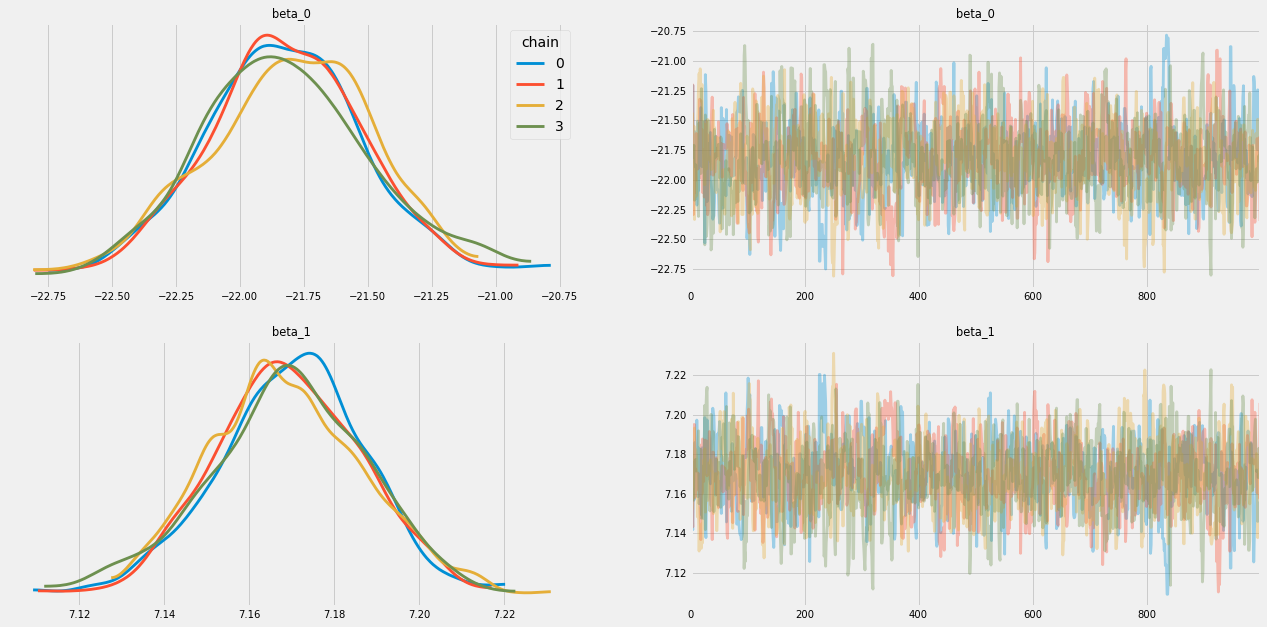

In [145]:
az.plot_trace(linear_trace, figsize = (20, 10), compact = False, legend = True)

In [146]:
with linear_model:
    trace_az = az.from_pymc3(linear_trace)
az.summary(trace_az)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-21.817,0.318,-22.390,-21.206,0.010,0.007,922.0,1233.0,1.0
beta_1,7.169,0.018,7.135,7.202,0.001,0.000,966.0,1148.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Lennovo\AppData\Roaming\Python\Python38\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


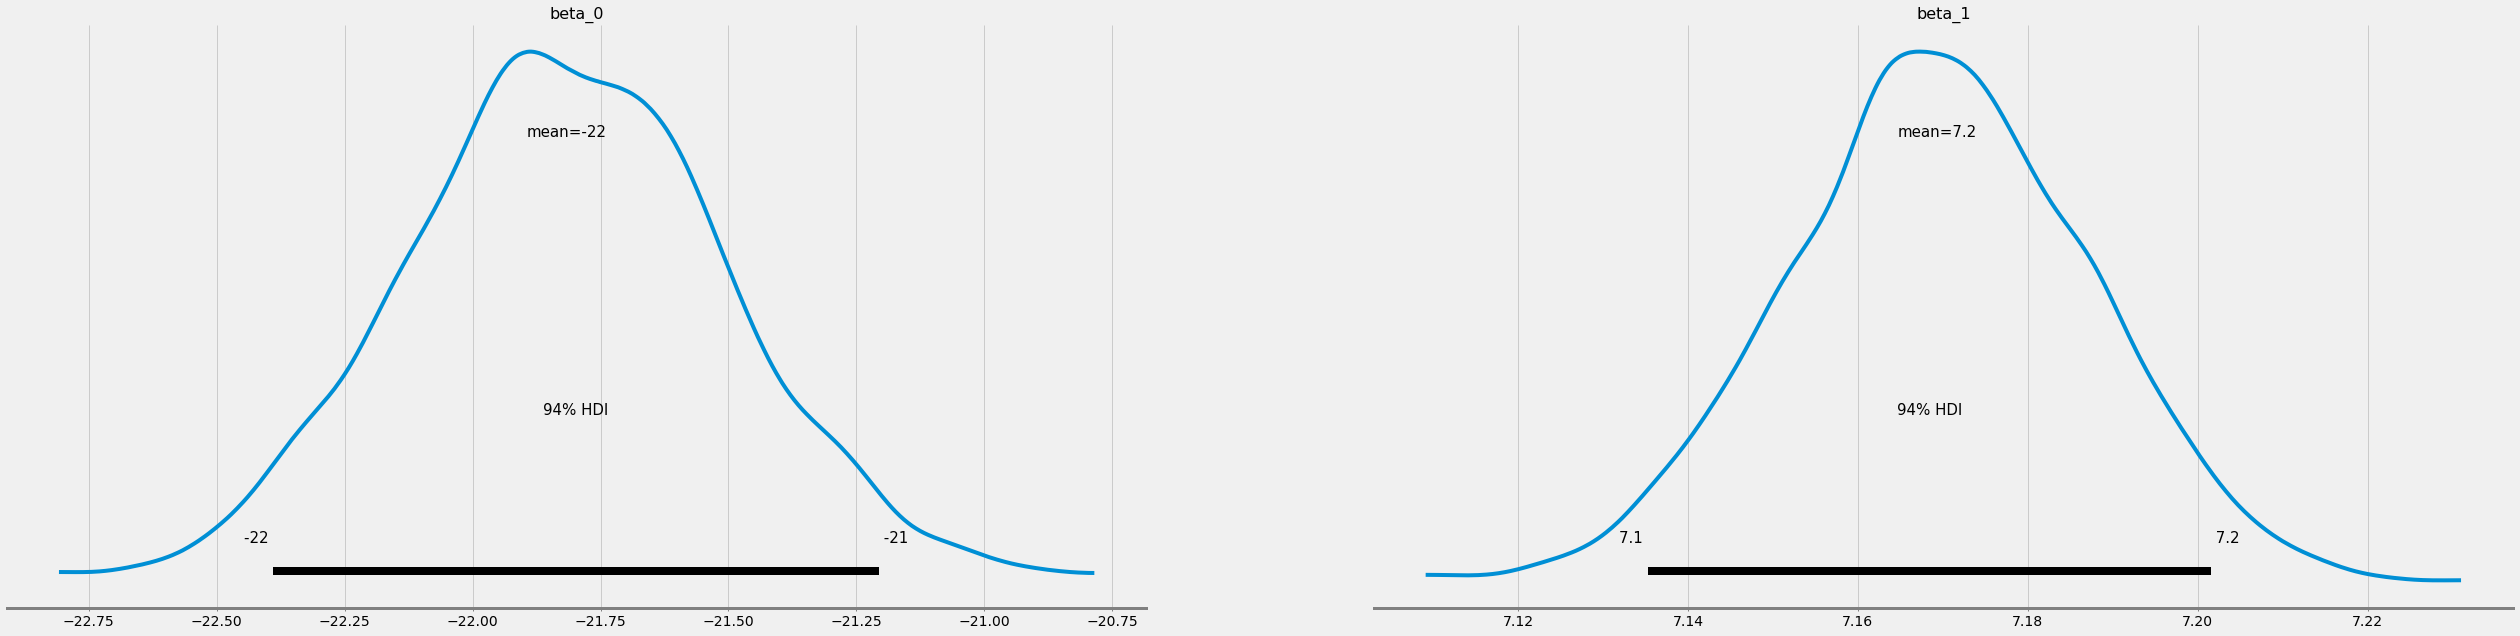

In [147]:
pm.plot_posterior(linear_trace, figsize = (40,10));

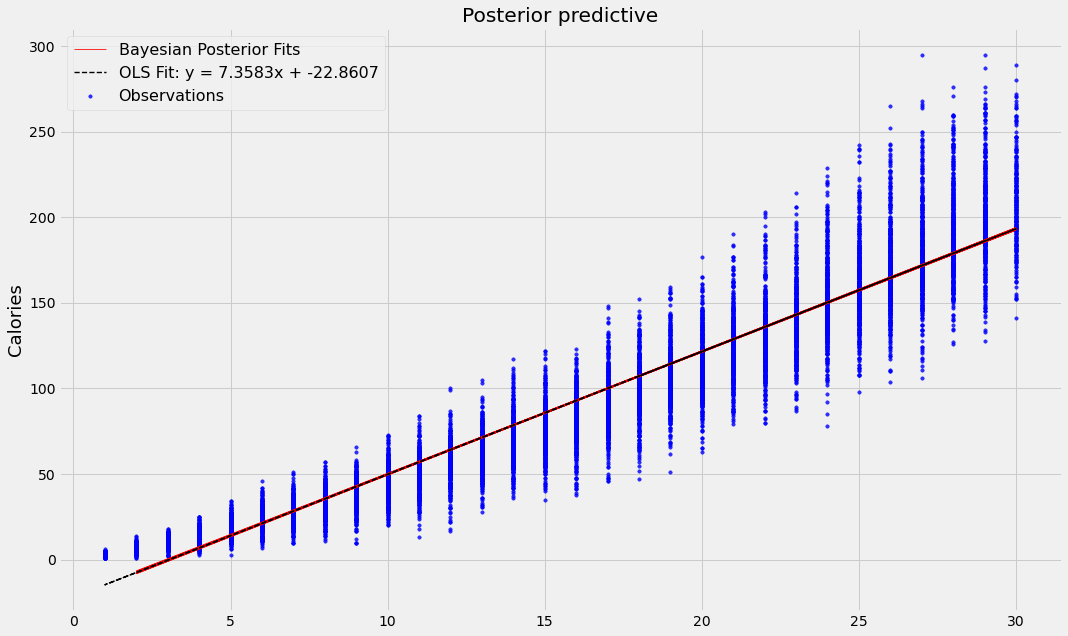

In [149]:
plt.figure(figsize = (16,10))
pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['beta_0'] + sample['beta_1'] * x);
plt.scatter(X['Duration'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X['Duration'], by_hand_coefs[0] + X['Duration'] * by_hand_coefs[1], 'k--', label = f'OLS Fit: y = {slope500_m:.4f}x + {Intercept500_m:.4f}', linewidth = 1.4)
# plt.title('Posterior Predictions with all Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

In [150]:
## Dự đoán với điểm dữ liệu x = 15.5
bayes_prediction15000 = linear_trace['beta_0'] + linear_trace['beta_1'] * 15.5

In [163]:
bayes_prediction15000.std()

0.15014942423434194

In [164]:
# tính khoảng tin cậy 95% cho dự báo điểm dữ liệu 15.5
low_15000 = bayes_prediction15000.mean() - 1.96*bayes_prediction15000.std()
high_15000 = bayes_prediction15000.mean() + 1.96*bayes_prediction15000.std()
print((round(low_15000, 4), round(high_15000, 4)))

(89.0129, 89.6015)


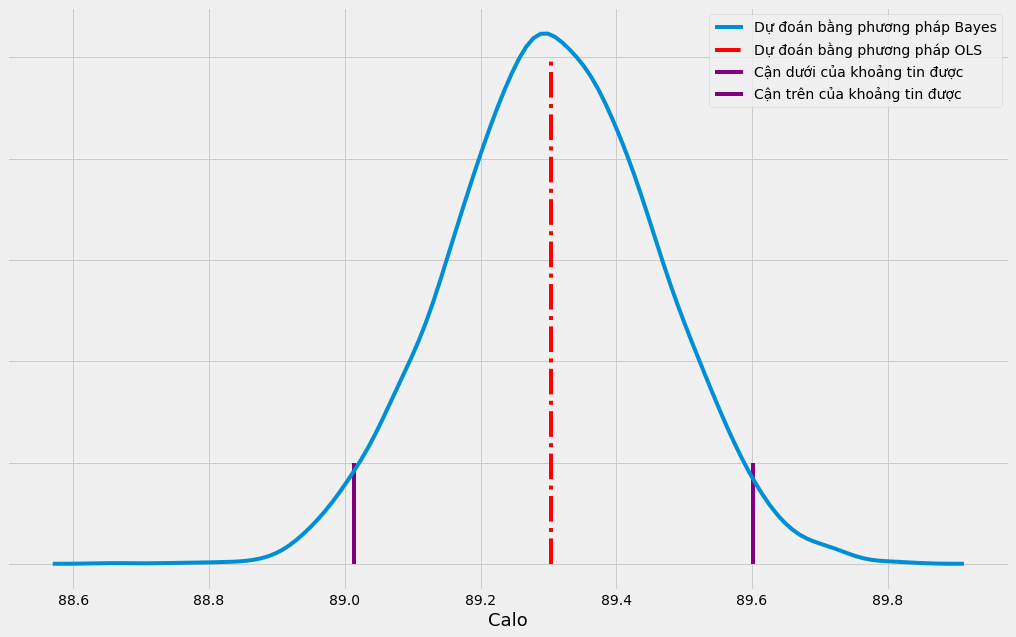

In [159]:
plt.figure(figsize = (16,10))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction15000, label = 'Dự đoán bằng phương pháp Bayes')
plt.vlines(x = by_hand_coefs[0] + by_hand_coefs[1] * 15.5, 
           ymin = 0, ymax = 2.5, 
           label = 'Dự đoán bằng phương pháp OLS',
          colors = 'red', linestyles='-.')
plt.vlines(x = low_15000, 
           ymin = 0, ymax = 0.5, 
           label = 'Cận dưới của khoảng tin được',
          colors = 'purple', linestyles='-')
plt.vlines(x = high_15000, 
           ymin = 0, ymax = 0.5, 
           label = 'Cận trên của khoảng tin được',
          colors = 'purple', linestyles='-')
plt.legend();
plt.xlabel('Calo', size = 18),
# plt.ylabel('Probability Density', size = 18);
# plt.title('Posterior Prediction for 15.5 Minutes', size = 20);
plt.tick_params(labelleft=False, left=False)